# Choroid Plexus and Thalamic Nuclei

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [2]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests
from IPython.display import clear_output

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [3]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors
from my_namespace import (
    presentation_cols
)
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [4]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/6-Thalamic_nuclei_and_disability"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data[MS_patients]
data_ms_z = zscore(data_ms)

resid_data_z = data_ms_z.copy()
resid_data = data_ms.copy()
for var in all_predictors:
    resid_data[var] = utils.residualize_structs(data_ms, var, ["age", "Female", "tiv"])
    resid_data_z[var] = utils.residualize_structs(
        data_ms_z, var, ["age", "Female", "tiv"]
    )


grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Functions

In [5]:
def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = (
        "/home/srs-9/Projects/ms_mri/analysis/thalamus/run_williams_hotelling.R"
    )

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["medial", "posterior", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct][0]) > abs(pearson_results["THALAMUS_1"][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps

## Results section 6


### Baseline associations with disability

In [7]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]

predictors = [
    "THALAMUS_1",
    "medial",
    "posterior",
    "ventral",
    "anterior",
    "cortical_thickness",
    "brain",
    "white",
    "grey",
    "CP",
    "t2lv_log",
    "PRL",
    "LV_log",
    "thirdV_log",
    "fourthV_log",
    "allCSF",
    "periCSF",
    # need to decide: CCR vs CCR2
    "CCR_log", 
    "CCR2_log",
    "periCSF_frac_reflect_log"
]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + age + Female + tiv + dzdur`

| predictor                |    coef |    pval |   p_fdr |     se | ci                |   R2 |
|:-------------------------|--------:|--------:|--------:|-------:|:------------------|-----:|
| THALAMUS_1               | -0.2553 | 1.6e-07 | 2.4e-06 | 0.0479 | [-0.349, -0.161]  | 0.29 |
| medial                   | -0.2039 | 1.2e-05 | 4.7e-05 | 0.046  | [-0.294, -0.113]  | 0.27 |
| posterior                | -0.2339 | 2.4e-07 | 2.4e-06 | 0.0446 | [-0.321, -0.146]  | 0.28 |
| ventral                  | -0.25   | 3.2e-06 | 2.1e-05 | 0.053  | [-0.354, -0.146]  | 0.28 |
| anterior                 | -0.2149 | 1.8e-05 | 6.1e-05 | 0.0496 | [-0.312, -0.117]  | 0.28 |
| cortical_thickness       | -0.195  | 8.1e-06 | 4.1e-05 | 0.0432 | [-0.28, -0.11]    | 0.27 |
| brain                    | -0.0666 | 0.16    | 0.19    | 0.0474 | [-0.16, 0.0267]   | 0.25 |
| white                    | -0.0196 | 0.67    | 0.7     | 0.0454 | [-0.109, 0.0696]  | 0.24 |
| grey                     | -0.092  | 0.069   | 0.086   | 0.0504 | [-0.191, 0.00706] | 0.25 |
| CP                       |  0.0535 | 0.22    | 0.25    | 0.0438 | [-0.0326, 0.139]  | 0.25 |
| t2lv_log                 |  0.1088 | 0.013   | 0.021   | 0.0434 | [0.0234, 0.194]   | 0.25 |
| PRL                      |  0.1024 | 0.013   | 0.021   | 0.0413 | [0.0213, 0.184]   | 0.25 |
| LV_log                   |  0.1569 | 0.00084 | 0.0016  | 0.0467 | [0.0652, 0.249]   | 0.26 |
| thirdV_log               |  0.1718 | 0.00035 | 0.00087 | 0.0476 | [0.0782, 0.265]   | 0.27 |
| fourthV_log              |  0.0848 | 0.048   | 0.064   | 0.0428 | [0.000675, 0.169] | 0.25 |
| allCSF                   |  0.1631 | 0.02    | 0.028   | 0.0697 | [0.026, 0.3]      | 0.25 |
| periCSF                  |  0.0262 | 0.7     | 0.7     | 0.0675 | [-0.106, 0.159]   | 0.24 |
| CCR_log                  |  0.1499 | 0.00088 | 0.0016  | 0.0448 | [0.0619, 0.238]   | 0.26 |
| CCR2_log                 |  0.1528 | 0.00073 | 0.0016  | 0.0449 | [0.0646, 0.241]   | 0.26 |
| periCSF_frac_reflect_log |  0.1685 | 0.00022 | 0.00062 | 0.0452 | [0.0797, 0.257]   | 0.27 |

`SDMT ~ *predictor* + age + Female + tiv + dzdur`

| predictor                |    coef |    pval |   p_fdr |     se | ci                |   R2 |
|:-------------------------|--------:|--------:|--------:|-------:|:------------------|-----:|
| THALAMUS_1               |  0.3731 | 4.3e-10 | 4.3e-09 | 0.0584 | [0.258, 0.488]    | 0.25 |
| medial                   |  0.3351 | 1.1e-09 | 7.2e-09 | 0.0538 | [0.229, 0.441]    | 0.23 |
| posterior                |  0.3342 | 2.9e-09 | 1.4e-08 | 0.0551 | [0.226, 0.443]    | 0.24 |
| ventral                  |  0.3557 | 3.6e-09 | 1.4e-08 | 0.0591 | [0.24, 0.472]     | 0.23 |
| anterior                 |  0.2657 | 6.5e-08 | 1.6e-07 | 0.0483 | [0.171, 0.361]    | 0.21 |
| cortical_thickness       |  0.3614 | 9.2e-13 | 1.8e-11 | 0.0491 | [0.265, 0.458]    | 0.25 |
| brain                    |  0.2312 | 1.6e-06 | 2.7e-06 | 0.0475 | [0.138, 0.325]    | 0.19 |
| white                    |  0.1022 | 0.031   | 0.034   | 0.0472 | [0.0095, 0.195]   | 0.16 |
| grey                     |  0.2896 | 7e-09   | 2e-08   | 0.049  | [0.193, 0.386]    | 0.21 |
| CP                       | -0.1554 | 0.006   | 0.007   | 0.0562 | [-0.266, -0.0449] | 0.17 |
| t2lv_log                 | -0.3146 | 4.2e-09 | 1.4e-08 | 0.0525 | [-0.418, -0.211]  | 0.24 |
| PRL                      | -0.1452 | 0.0045  | 0.0057  | 0.0509 | [-0.245, -0.0451] | 0.17 |
| LV_log                   | -0.2875 | 5.4e-07 | 1.2e-06 | 0.0565 | [-0.399, -0.176]  | 0.22 |
| thirdV_log               | -0.2432 | 9e-06   | 1.2e-05 | 0.0541 | [-0.35, -0.137]   | 0.2  |
| fourthV_log              | -0.0957 | 0.054   | 0.054   | 0.0495 | [-0.193, 0.00153] | 0.16 |
| allCSF                   | -0.3351 | 4.5e-06 | 6.9e-06 | 0.0722 | [-0.477, -0.193]  | 0.2  |
| periCSF                  | -0.1347 | 0.052   | 0.054   | 0.069  | [-0.27, 0.000954] | 0.16 |
| CCR_log                  | -0.2655 | 1.6e-06 | 2.7e-06 | 0.0546 | [-0.373, -0.158]  | 0.21 |
| CCR2_log                 | -0.2673 | 1.5e-06 | 2.7e-06 | 0.0548 | [-0.375, -0.16]   | 0.21 |
| periCSF_frac_reflect_log | -0.2567 | 9.3e-06 | 1.2e-05 | 0.0572 | [-0.369, -0.144]  | 0.21 |

### Regional Thalamic Atrophy

**No thalamic nucleus predicts disability after controlling for global thalamic atrophy**

In [135]:
model_data = data_ms_z
save_path = fig_path / "edss_all_predictors.xlsx"
covariates = ["age", "Female", "tiv", "dzdur"]

outcomes = ["EDSS_sqrt", "SDMT"]
predictors = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]
covariates = ["THALAMUS_1", "age", "Female", "tiv", "dzdur"]

results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictors,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = (
        results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    )
    display(Markdown(f"`{outcome} ~ *predictor* + {' + '.join(covariates)}`"))
    display(
        Markdown(
            regutils.present_model(results_to_display, presentation_cols, inds=display_order).to_markdown()
        )
    )

`EDSS_sqrt ~ *predictor* + THALAMUS_1 + age + Female + tiv + dzdur`

| predictor   |    coef |   pval |   p_fdr |     se | ci               |   R2 |
|:------------|--------:|-------:|--------:|-------:|:-----------------|-----:|
| medial      |  0.1351 |   0.25 |    0.51 | 0.1182 | [-0.0971, 0.367] | 0.29 |
| anterior    | -0.105  |   0.12 |    0.47 | 0.0668 | [-0.236, 0.0261] | 0.29 |
| posterior   | -0.093  |   0.48 |    0.55 | 0.1325 | [-0.353, 0.167]  | 0.29 |
| ventral     | -0.0645 |   0.55 |    0.55 | 0.1077 | [-0.276, 0.147]  | 0.29 |

`SDMT ~ *predictor* + THALAMUS_1 + age + Female + tiv + dzdur`

| predictor   |   coef |   pval |   p_fdr |     se | ci               |   R2 |
|:------------|-------:|-------:|--------:|-------:|:-----------------|-----:|
| posterior   | 0.0717 |   0.57 |    0.81 | 0.1264 | [-0.177, 0.32]   | 0.25 |
| anterior    | 0.0661 |   0.27 |    0.81 | 0.0596 | [-0.0509, 0.183] | 0.25 |
| ventral     | 0.0548 |   0.61 |    0.81 | 0.107  | [-0.155, 0.265]  | 0.25 |
| medial      | 0.0323 |   0.81 |    0.81 | 0.1359 | [-0.235, 0.299]  | 0.25 |

### Moderated Mediation Models


The effect of CP on thalamus is fully mediated by LV expansion

In [6]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="THALAMUS_1",
    m=["LV_log"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.5922   0.5860 0.4148 111.3322    6  460   0.0000

Coefficients

         coeff     se        t      p    LLCI    ULCI
Cons    0.0017 0.0298   0.0575 0.9542 -0.0567  0.0601
CP     -0.0644 0.0446  -1.4433 0.1496 -0.1519  0.0231
age     0.0395 0.0397   0.9941 0.3207 -0.0384  0.1173
Female  0.1265 0.0365   3.4624 0.0006  0.0549  0.1982
tiv     0.5735 0.0360  15.9407 0.0000  0.5030  0.6440
dzdur  -0.2049 0.0376  -5.4526 0.0000 -0.2785 -0.1312
LV_log -0.5238 0.0459 -11.4159 0.0000 -0.6137 -0.4338

-------------------------------------------------------------------------

Outcome = LV_log 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.5781   0.5726 0.4274 126.3164    5  461   0.0000

Coefficients

        coeff     se       t      p    LLCI   ULCI
Cons   0.0015 0.0303  0.0506 0.9597 -0.

Thalamic atrophy occurs both through direct periventricular tissue injury and via Wallerian degeneration. These processes have a multiplicitive effect.

In [18]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=1,
    x="LV_log",
    y="THALAMUS_1",
    m="t2lv_log",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6494   0.6432 0.3574 121.4361    7  459   0.0000

Coefficients

                  coeff     se        t      p    LLCI    ULCI
Cons             0.0501 0.0304   1.6479 0.1001 -0.0095  0.1096
LV_log          -0.4457 0.0354 -12.5846 0.0000 -0.5151 -0.3762
t2lv_log        -0.2490 0.0329  -7.5660 0.0000 -0.3135 -0.1845
LV_log*t2lv_log -0.0963 0.0247  -3.9033 0.0001 -0.1447 -0.0480
age              0.0294 0.0368   0.8008 0.4236 -0.0426  0.1015
Female           0.1430 0.0333   4.2974 0.0000  0.0778  0.2082
tiv              0.5687 0.0332  17.1090 0.0000  0.5035  0.6338
dzdur           -0.1513 0.0354  -4.2728 0.0000 -0.2207 -0.0819

-------------------------------------------------------------------------


********************** CONDITIONAL EFFECTS **********************

Conditional effect(s) of LV_log on THALAMUS_1 at

In [14]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="LV_log",
    m=["THALAMUS_1"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = LV_log 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6712   0.6662 0.3338 156.5134    6  460   0.0000

Coefficients

             coeff     se        t      p    LLCI    ULCI
Cons        0.0019 0.0267   0.0716 0.9429 -0.0505  0.0543
CP          0.4710 0.0336  14.0232 0.0000  0.4052  0.5368
age         0.1276 0.0352   3.6290 0.0003  0.0587  0.1966
Female      0.0945 0.0329   2.8706 0.0043  0.0300  0.1590
tiv         0.3683 0.0364  10.1292 0.0000  0.2971  0.4396
dzdur      -0.0225 0.0348  -0.6464 0.5183 -0.0906  0.0457
THALAMUS_1 -0.4215 0.0369 -11.4159 0.0000 -0.4939 -0.3491

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.4767   0.4698 0.5311 83.9764    5  461   0.0000

Coefficients

         coeff     se        t      p    LLCI    ULCI
Cons  

In [9]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CCR2_log",
    y="EDSS_sqrt",
    m=["THALAMUS_1"],
    w="t2lv_log",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2947   0.2836 0.7178 30.9862    6  445   0.0000

Coefficients

             coeff     se       t      p    LLCI    ULCI
Cons       -0.0115 0.0399 -0.2873 0.7740 -0.0896  0.0667
CCR2_log    0.0250 0.0552  0.4529 0.6508 -0.0832  0.1332
age         0.2694 0.0527  5.1162 0.0000  0.1662  0.3726
Female     -0.0648 0.0481 -1.3464 0.1789 -0.1592  0.0295
tiv         0.0135 0.0567  0.2372 0.8126 -0.0978  0.1247
dzdur       0.1502 0.0514  2.9200 0.0037  0.0494  0.2510
THALAMUS_1 -0.2396 0.0606 -3.9548 0.0001 -0.3584 -0.1209

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6303   0.6236 0.3802 108.1456    7  444   0.0000

Coefficients

                    coeff     se        t      p    LLCI    ULCI


In [10]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="THALAMUS_1",
    y="EDSS_sqrt",
    m=["CCR2_log"],
    w="t2lv_log",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2947   0.2836 0.7178 30.9862    6  445   0.0000

Coefficients

             coeff     se       t      p    LLCI    ULCI
Cons       -0.0115 0.0399 -0.2873 0.7740 -0.0896  0.0667
THALAMUS_1 -0.2396 0.0606 -3.9548 0.0001 -0.3584 -0.1209
age         0.2694 0.0527  5.1162 0.0000  0.1662  0.3726
Female     -0.0648 0.0481 -1.3464 0.1789 -0.1592  0.0295
tiv         0.0135 0.0567  0.2372 0.8126 -0.0978  0.1247
dzdur       0.1502 0.0514  2.9200 0.0037  0.0494  0.2510
CCR2_log    0.0250 0.0552  0.4529 0.6508 -0.0832  0.1332

-------------------------------------------------------------------------

Outcome = CCR2_log 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5019   0.4929 0.5084 63.9141    7  444   0.0000

Coefficients

                      coeff     se        t      p    LLCI    ULCI
Co

In [8]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="CP",
    y="EDSS_sqrt",
    w="t2lv_log",
    m=["CCR2_log"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2722   0.2607 0.7407 27.7379    6  445   0.0000

Coefficients

           coeff     se       t      p    LLCI    ULCI
Cons     -0.0096 0.0405 -0.2358 0.8137 -0.0889  0.0698
CP       -0.0693 0.0584 -1.1875 0.2357 -0.1837  0.0451
age       0.2704 0.0538  5.0260 0.0000  0.1650  0.3759
Female   -0.1089 0.0491 -2.2183 0.0270 -0.2051 -0.0127
tiv      -0.1130 0.0477 -2.3673 0.0183 -0.2066 -0.0194
dzdur     0.1988 0.0507  3.9185 0.0001  0.0994  0.2983
CCR2_log  0.1959 0.0582  3.3675 0.0008  0.0819  0.3099

-------------------------------------------------------------------------

Outcome = CCR2_log 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5647   0.5569 0.4442 82.2975    7  444   0.0000

Coefficients

              coeff     se       t      p    LLCI   ULCI
Cons         0.0046 0.0339  

In [67]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="EDSS_sqrt",
    m=["THALAMUS_1", "cortical_thickness"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2995   0.2869 0.7131 27.1804    7  445   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0128 0.0397 -0.3236 0.7464 -0.0906  0.0650
CP                 -0.0652 0.0499 -1.3058 0.1923 -0.1629  0.0326
age                 0.2685 0.0541  4.9612 0.0000  0.1624  0.3745
Female             -0.0693 0.0484 -1.4337 0.1524 -0.1641  0.0254
tiv                 0.0288 0.0545  0.5279 0.5978 -0.0781  0.1356
dzdur               0.1503 0.0513  2.9313 0.0035  0.0498  0.2508
THALAMUS_1         -0.2331 0.0661 -3.5289 0.0005 -0.3626 -0.1036
cortical_thickness -0.0803 0.0589 -1.3628 0.1736 -0.1957  0.0352

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.4

In [59]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=4,
    x="CP",
    y="SDMT",
    m=["cortical_thickness", "THALAMUS_1"],
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2807   0.2678 0.7322 24.8632    7  446   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons                0.0078 0.0402  0.1945 0.8459 -0.0709  0.0866
CP                  0.0109 0.0512  0.2124 0.8319 -0.0895  0.1112
age                -0.2039 0.0548 -3.7205 0.0002 -0.3113 -0.0965
Female              0.0667 0.0493  1.3534 0.1766 -0.0299  0.1632
tiv                 0.0194 0.0553  0.3503 0.7263 -0.0889  0.1277
dzdur               0.0445 0.0522  0.8526 0.3943 -0.0578  0.1467
cortical_thickness  0.2362 0.0593  3.9796 0.0001  0.1199  0.3525
THALAMUS_1          0.2223 0.0667  3.3352 0.0009  0.0917  0.3529

-------------------------------------------------------------------------

Outcome = cortical_thickness 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 

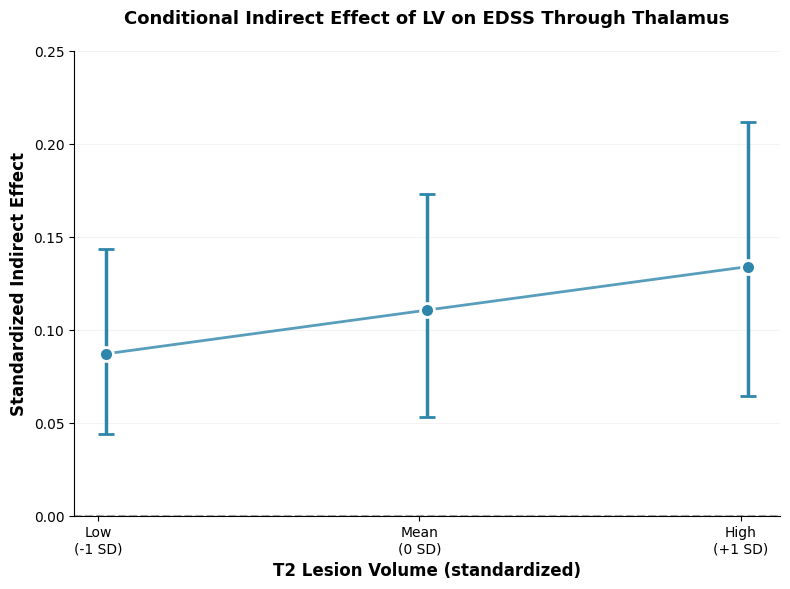

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Data
t2lv_values = np.array([-0.9745, 0.0234, 1.0213])
indirect_effects = np.array([0.0870, 0.1105, 0.1339])
ci_lower = np.array([0.0439, 0.0532, 0.0641])
ci_upper = np.array([0.1432, 0.1729, 0.2115])

# Calculate errors
errors_lower = indirect_effects - ci_lower
errors_upper = ci_upper - indirect_effects
errors = np.array([errors_lower, errors_upper])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(t2lv_values, indirect_effects, '-o', 
        color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)

# Add error bars
ax.errorbar(t2lv_values, indirect_effects, yerr=errors,
            fmt='o', markersize=10, 
            color='#2E86AB', ecolor='#2E86AB', 
            capsize=6, capthick=2.5, linewidth=2.5,
            markeredgewidth=2, markeredgecolor='white')


# ax.errorbar(t2lv_levels, indirect_effects, 
#             yerr=errors, fmt='o', markersize=10, 
#             color='#2E86AB', ecolor='#2E86AB', 
#             capsize=6, capthick=2.5, linewidth=2.5,
#             markeredgewidth=2, markeredgecolor='white')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Customize plot
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Low\n(-1 SD)', 'Mean\n(0 SD)', 'High\n(+1 SD)'])
ax.set_xlabel('T2 Lesion Volume (standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Standardized Indirect Effect', fontsize=12, fontweight='bold')
ax.set_title('Conditional Indirect Effect of LV on EDSS Through Thalamus',
             fontsize=13, fontweight='bold', pad=20)
ax.set_ylim(0, 0.25)
# ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)



ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

In [110]:
model_data = data_ms_z

p2 = Process(
    data=model_data,
    model=7,
    x="LV_log",
    y="SDMT",
    m=["THALAMUS_1"],
    w="t2lv_log",
    controls=["age", "Female", "tiv", "dzdur"],
    controls_in="all",
    suppr_init=True,
)

p2.summary()


***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2621   0.2505 0.7510 26.4093    6  446   0.0000

Coefficients

             coeff     se       t      p    LLCI    ULCI
Cons        0.0078 0.0407  0.1918 0.8480 -0.0720  0.0876
LV_log     -0.1109 0.0606 -1.8307 0.0678 -0.2296  0.0078
age        -0.2355 0.0546 -4.3174 0.0000 -0.3424 -0.1286
Female      0.0812 0.0494  1.6428 0.1011 -0.0157  0.1781
tiv         0.0464 0.0615  0.7551 0.4506 -0.0740  0.1669
dzdur       0.0473 0.0529  0.8946 0.3715 -0.0563  0.1509
THALAMUS_1  0.3036 0.0633  4.7975 0.0000  0.1796  0.4276

-------------------------------------------------------------------------

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.6402   0.6337 0.3631 113.1241    7  445   0.0000

Coefficients

                  coeff     se        t      p    LLCI    ULCI
Cons   

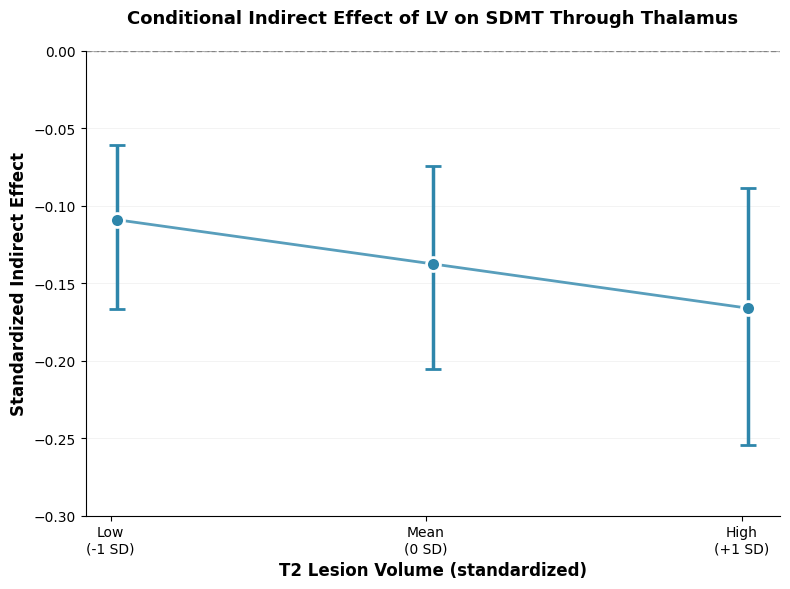

In [6]:
# Data
t2lv_values = np.array([-0.9788, 0.0215, 1.0218])
indirect_effects = np.array([-0.1091, -0.1376, -0.1662])
ci_lower = np.array([-0.1667, -0.2056, -0.2543])
ci_upper = np.array([-0.0610, -0.0745, -0.0885])

# Calculate errors
errors_lower = indirect_effects - ci_lower
errors_upper = ci_upper - indirect_effects
errors = np.array([errors_lower, errors_upper])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line and points
ax.plot(t2lv_values, indirect_effects, '-o', 
        color='#2E86AB', linewidth=2, markersize=8, alpha=0.8)

# Add error bars
ax.errorbar(t2lv_values, indirect_effects, yerr=errors,
            fmt='o', markersize=10, 
            color='#2E86AB', ecolor='#2E86AB', 
            capsize=6, capthick=2.5, linewidth=2.5,
            markeredgewidth=2, markeredgecolor='white')


# ax.errorbar(t2lv_levels, indirect_effects, 
#             yerr=errors, fmt='o', markersize=10, 
#             color='#2E86AB', ecolor='#2E86AB', 
#             capsize=6, capthick=2.5, linewidth=2.5,
#             markeredgewidth=2, markeredgecolor='white')

# Add horizontal line at zero
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Customize plot
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Low\n(-1 SD)', 'Mean\n(0 SD)', 'High\n(+1 SD)'])
ax.set_xlabel('T2 Lesion Volume (standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Standardized Indirect Effect', fontsize=12, fontweight='bold')
ax.set_title('Conditional Indirect Effect of LV on SDMT Through Thalamus',
             fontsize=13, fontweight='bold', pad=20)
ax.set_ylim(-0.3, 0)
# ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)



ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

In [52]:
model_data.to_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/R_data/model_data.csv")

In [73]:
formula = "SDMT ~ t2lv_log*LV_log + age + Female + tiv"
model = sm.OLS.from_formula(formula, data=data_ms_z).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SDMT   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     28.93
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           2.97e-29
Time:                        19:22:12   Log-Likelihood:                -568.81
No. Observations:                 453   AIC:                             1152.
Df Residuals:                     446   BIC:                             1180.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0609      0.044     

---

### Assumption Checks

Linearity

Check: Residual plots, component-residual plots
Test: Look for curved patterns in residuals vs. fitted values

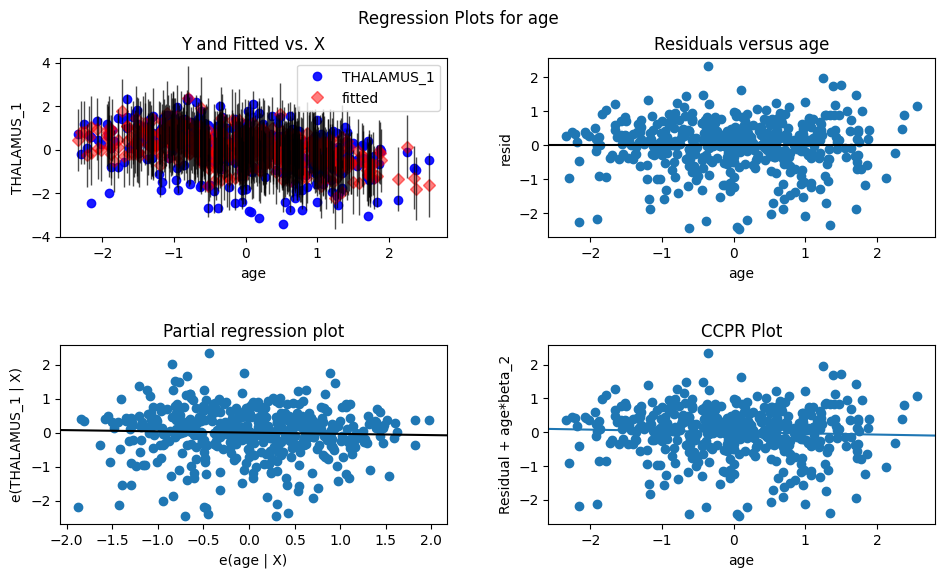

Breusch-Pagan p-value: 5.506487166550046e-07


In [129]:
from statsmodels.stats.diagnostic import het_breuschpagan

model_data = data_ms_z

model1 = sm.OLS.from_formula("THALAMUS_1 ~ CP + age + Female + tiv + dzdur", data=model_data).fit()
# model1 = sm.OLS.from_formula("EDSS_sqrt ~ THALAMUS_1 + age + Female + tiv + dzdur", data=model_data).fit()

fig = sm.graphics.plot_regress_exog(model1, 'age')
fig.set_figheight(6)
fig.set_figwidth(10)
plt.show()

bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

In [133]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# For the Thalamus model with interaction
model_data['LV_log:t2lv_log'] = model_data['LV_log']*model_data['t2lv_log']
X = model_data[['LV_log', 't2lv_log', 'LV_log:t2lv_log', 'age', 'Female', 'tiv', 'dzdur']]
X = X.dropna()
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Variable       VIF
0           LV_log  1.638503
1         t2lv_log  1.412942
2  LV_log:t2lv_log  1.016891
3              age  1.763286
4           Female  1.438500
5              tiv  1.441871
6            dzdur  1.640535


---

### LV expansion and thalamic volumes

Does thalamic volume loss have regional relationships with expansion of the central CSF compartment?

**Steps**

1. Residualize out the effect of age, sex, TIV, and peripheral CSF volume from LV and each of the thalamic nuclei
2. Compute the Pearson correlations (r) between the residualized CP and each of the nuclei as well as the whole thalamus
3. Use the [Williams-Hotelling test](https://rdrr.io/github/bcdudek/bcdstats/man/test2r.t2.html) to compare the sizes of the r's (this procedure was used in Bergsland et al. 2020 as well)

In [24]:
disease_group = "MS"
influenced_var = "EDSS_sqrt"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["periCSF", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [25]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(
    Markdown(
        f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"
    )
)
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and EDSS_sqrt:**

```visualprolog
THALAMUS_1: r=-0.286, p=5.69e-10
medial: r=-0.242, p=1.80e-07
posterior: r=-0.278, p=1.78e-09
anterior: r=-0.244, p=1.52e-07
ventral: r=-0.264, p=1.26e-08
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
- medial < THALAMUS_1: p=1.49e-02
  posterior = THALAMUS_1: p=6.20e-01
  anterior = THALAMUS_1: p=2.61e-01
  ventral = THALAMUS_1: p=3.17e-01
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=1.41e-01
  medial = anterior: p=9.73e-01
  medial = ventral: p=5.23e-01
  posterior = anterior: p=3.87e-01
  posterior = ventral: p=6.75e-01
  anterior = ventral: p=6.29e-01
```


---